#Importing Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from PIL import Image
from glob import glob

%matplotlib inline

#Mount Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Assigning Path for Dataset


In [8]:
classes = 10

data = []
labels = []

target_size = (224, 224)
batch_size = 32

train_dir = '/content/drive/MyDrive/Colab Notebooks/Train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/Meta'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Test'

#Label Overview

In [9]:
classes_folders = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No Over taking'}

class_labels_df = pd.DataFrame(list(classes_folders.items()), columns=['ClassId', 'SignName'])

class_labels_df.to_csv('/content/drive/MyDrive/Colab Notebooks/class_labels.csv', index=False)

#Visualizing The Dataset

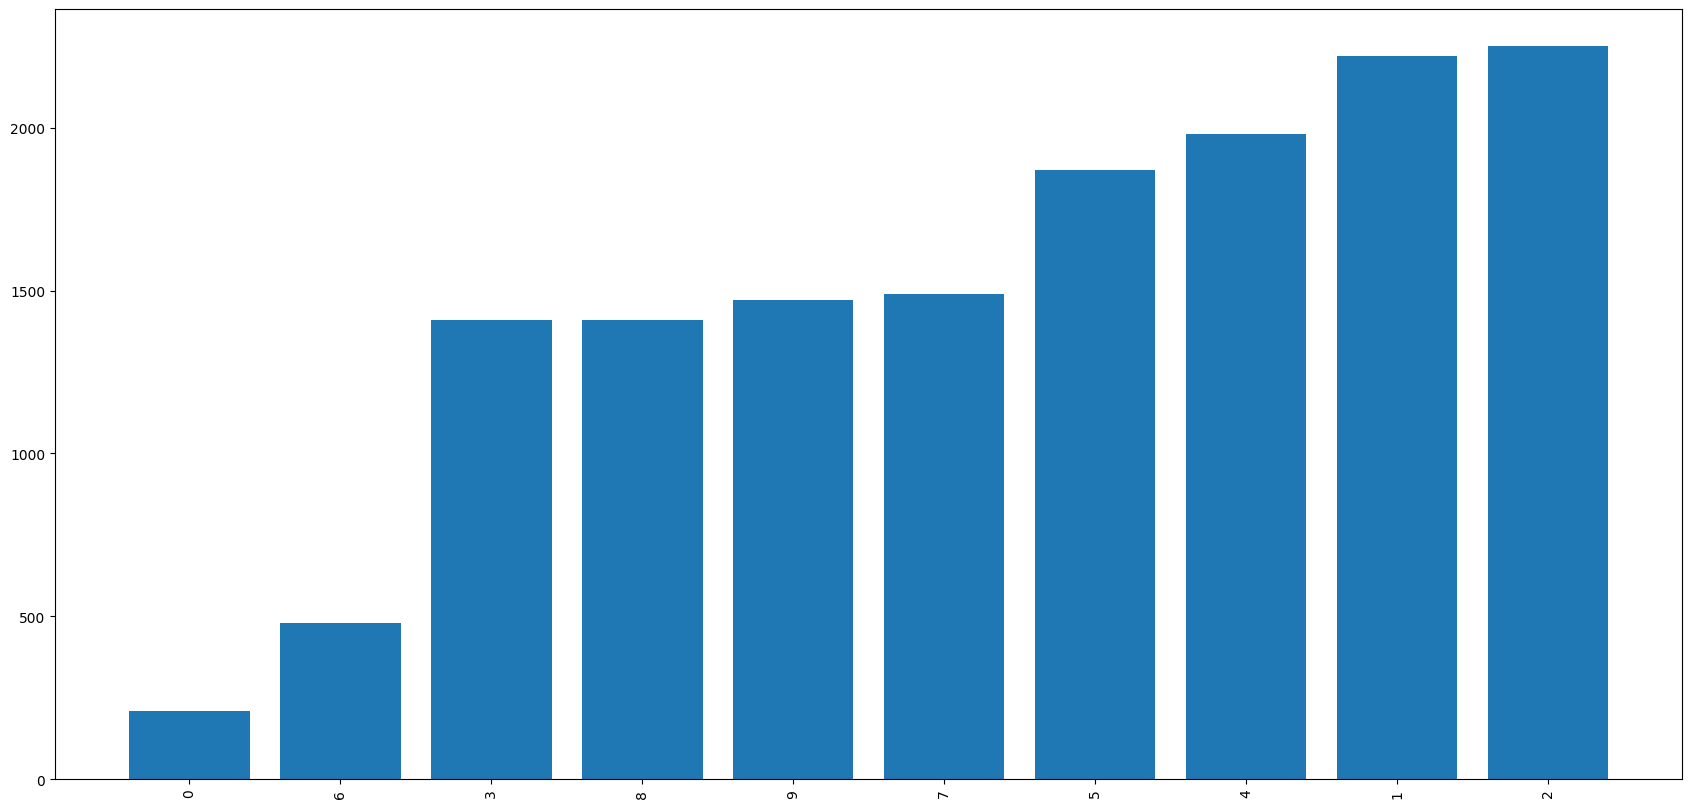

In [10]:
folders = os.listdir(train_dir)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_dir + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(folder)

zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [list(tuple) for tuple in tuples]

plt.figure(figsize=(21, 10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

# Visualizing 10 images from test data

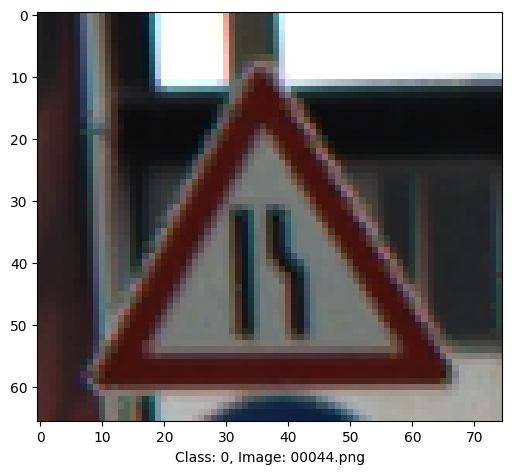

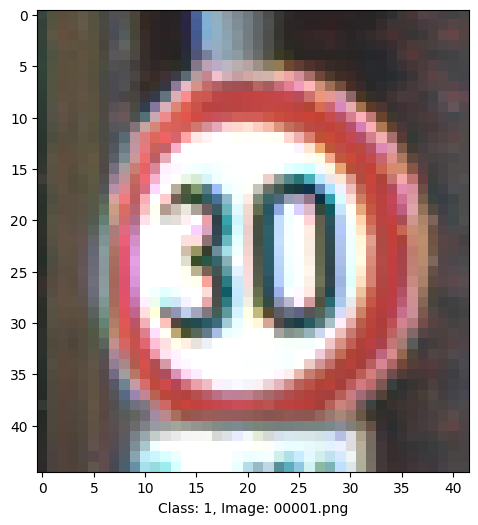

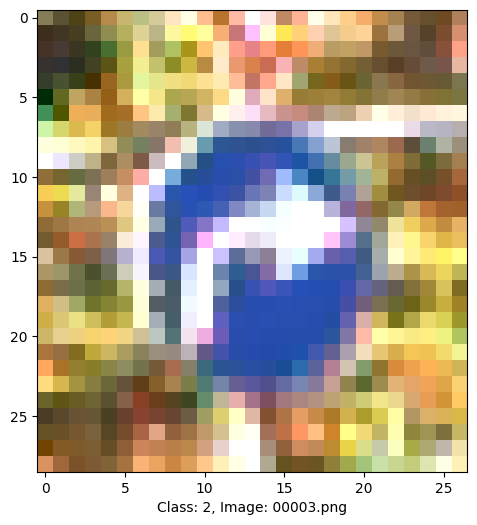

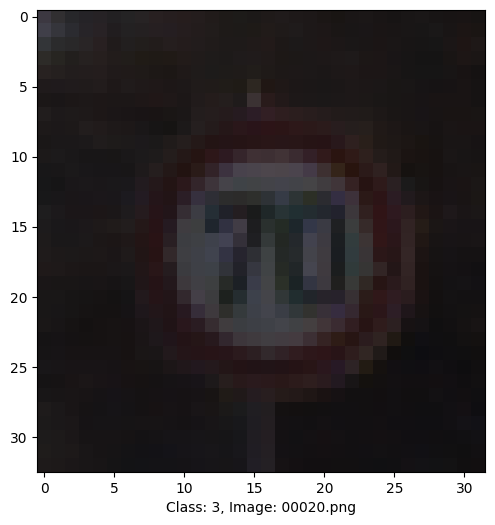

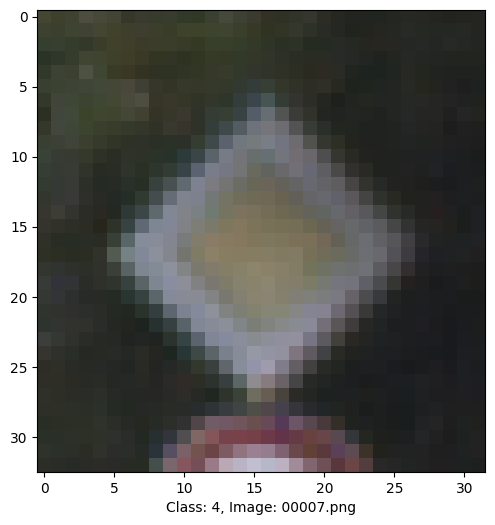

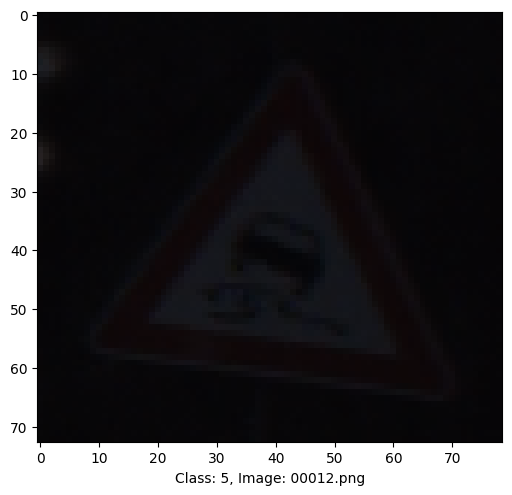

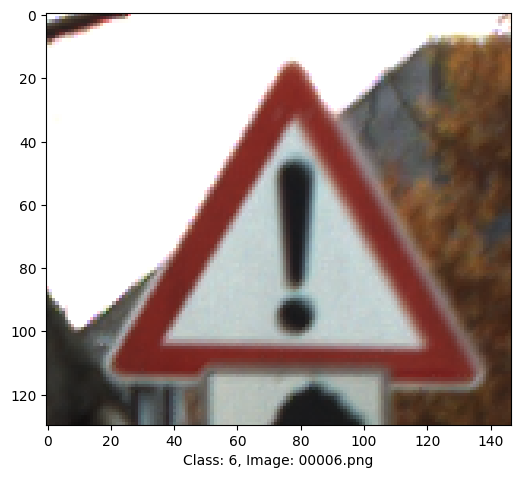

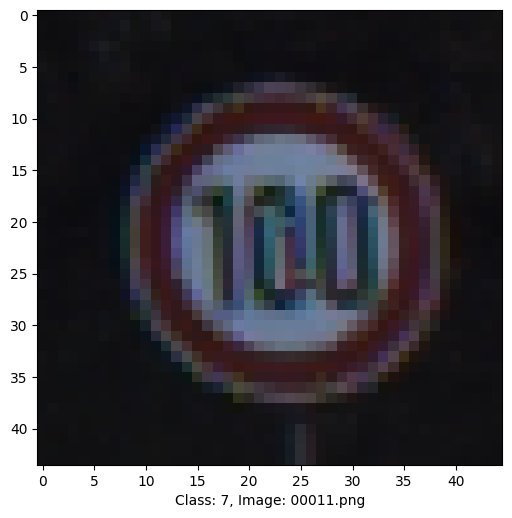

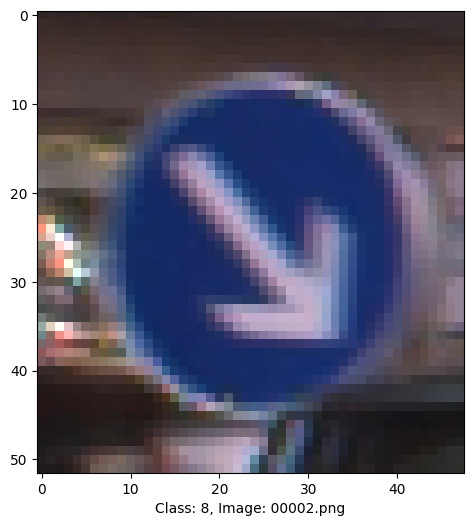

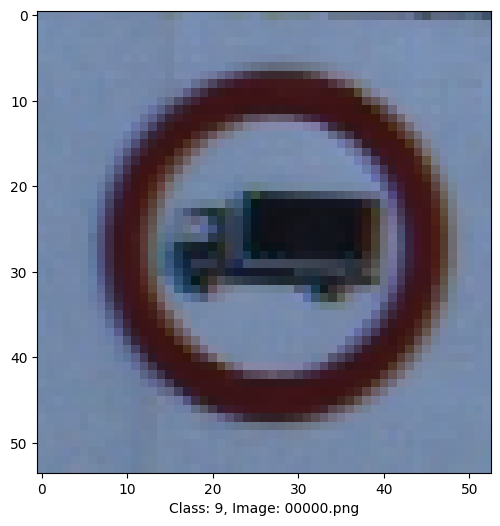

In [11]:
import os
import matplotlib.pyplot as plt

test_dir = '/content/drive/MyDrive/Colab Notebooks/Test'


class_subdirs = [os.path.join(test_dir, d) for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
class_subdirs.sort()

for subdir in class_subdirs:
    test_files = os.listdir(subdir)
    test_files.sort()

    if not test_files:
        continue

    image_filename = test_files[0]
    path = os.path.join(subdir, image_filename)
    img = plt.imread(path)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.xlabel('Class: {}, Image: {}'.format(os.path.basename(subdir), image_filename))
    plt.show()

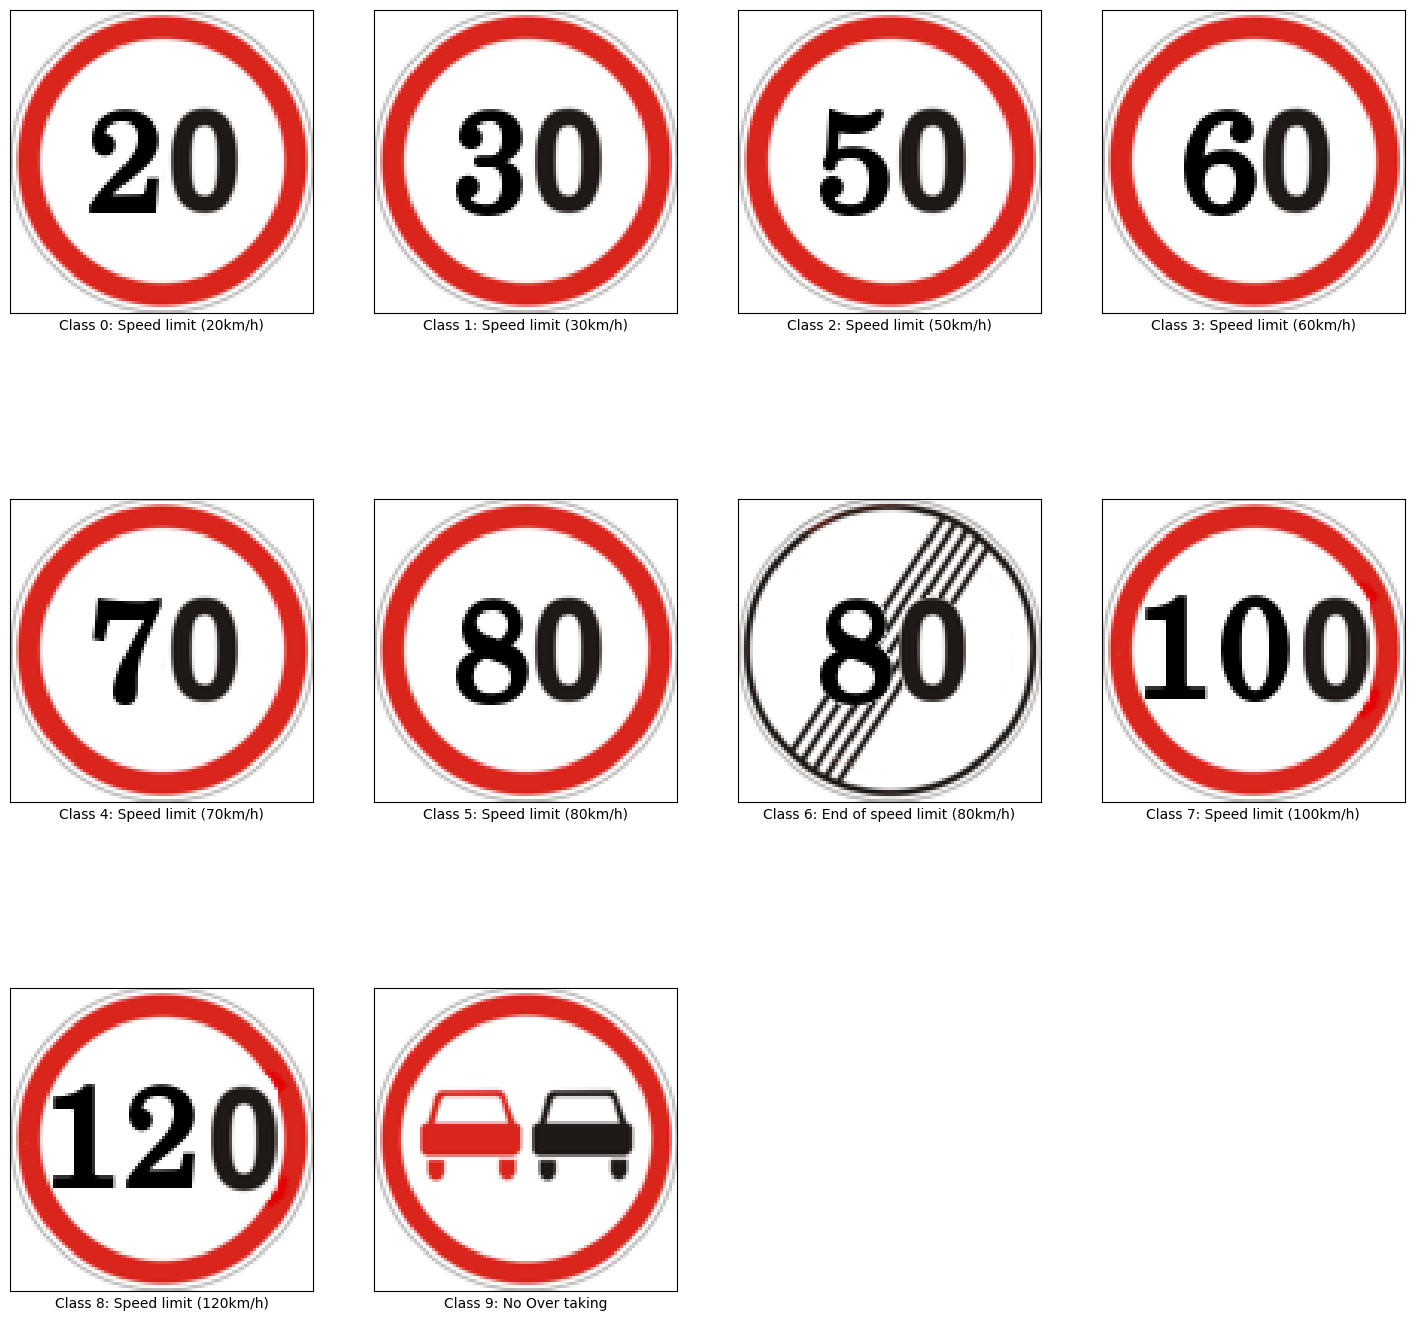

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/class_labels.csv')

class_names = labels_df.set_index('ClassId').to_dict()['SignName']

plt.figure(figsize=(18, 18))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    image_filename = "{}.png".format(i)
    path = "/content/drive/MyDrive/Colab Notebooks/Meta/" + image_filename
    img = plt.imread(path)
    plt.imshow(img)
    class_name = class_names.get(i, "Unknown")
    plt.xlabel(f'Class {i}: {class_name}')

plt.show()

#Load the Train Folder and Generator


In [13]:
train_image_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSV Files/Train.csv')
train_image_data.describe
train_image_data.value_counts().to_dict()

{(25, 25, 5, 5, 20, 20, 2, 'Train/2/00002_00017_00000.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00055_00024.png'): 1,
 (52, 51, 6, 5, 47, 46, 9, 'Train/9/00009_00008_00025.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00004_00026.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00006_00023.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00012_00027.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00013_00018.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00018_00020.png'): 1,
 (52, 51, 6, 5, 47, 46, 10, 'Train/10/00010_00028_00024.png'): 1,
 (52, 51, 6, 5, 47, 46, 12, 'Train/12/00012_00014_00018.png'): 1,
 (52, 51, 5, 6, 47, 46, 18, 'Train/18/00018_00018_00008.png'): 1,
 (52, 51, 6, 5, 47, 46, 14, 'Train/14/00014_00003_00009.png'): 1,
 (52, 51, 6, 5, 47, 46, 15, 'Train/15/00015_00009_00016.png'): 1,
 (52, 51, 6, 5, 47, 46, 16, 'Train/16/00016_00002_00025.png'): 1,
 (52, 51, 6, 5, 47, 46, 16, 'Train/16/00016_00007_00027.png'): 1,
 (52, 51, 6, 5

In [14]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

train_dir = '/content/drive/MyDrive/Colab Notebooks/Train'
validation_dir = '/content/drive/MyDrive/Colab Notebooks/Meta'

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

class_labels_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/class_labels.csv')
class_labels_df['ClassId'] = class_labels_df['ClassId'].astype(str)

meta_images = {f"{i}.png": str(i) for i in range(10)}
meta_df = pd.DataFrame(list(meta_images.items()), columns=['Path', 'ClassId'])

validation_df = meta_df.join(class_labels_df.set_index('ClassId'), on='ClassId')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=validation_dir,
    x_col='Path',
    y_col='SignName',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    shuffle=False)

validation_steps = max(validation_generator.samples // validation_generator.batch_size, 1)
print(f"Validation steps: {validation_steps}")

Found 14790 images belonging to 10 classes.
Found 10 validated image filenames belonging to 10 classes.
Validation steps: 1


In [15]:
print(train_generator.samples)

14790


#Train the Model and Save

In [16]:
print(f"Number of validation samples: {validation_generator.samples}")

if validation_generator.samples > 0:
    validation_steps = validation_generator.samples // validation_generator.batch_size
    print(f"Validation steps: {validation_steps}")
else:
    raise ValueError("Validation generator has no samples. Check the data loading process.")

Number of validation samples: 10
Validation steps: 1


In [17]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

print(f"Batch size: {train_generator.batch_size}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

if steps_per_epoch == 0 or validation_steps == 0:
    raise ValueError("The `steps_per_epoch` or `validation_steps` should not be 0")

Batch size: 32
Steps per epoch: 462
Validation steps: 1


#Section 1: Model Loading and Compilation

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import os

model_path = '/content/drive/MyDrive/best_model.h5'

model = load_model(model_path)

model.compile(optimizer=Adam(learning_rate=0.0001), # Reduced rate of learning, could be resulting in bad training and furthering the overfitting issue.
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print("Model loaded and compiled.")

Model loaded and compiled.


#Section 2: Model Training / Fine Tuning Overfitting

Epoch 1/2
462/462 [==============================] - ETA: 0s - loss: 0.5516 - accuracy: 0.8127 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_further_trained_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


462/462 [==============================] - 8418s 18s/step - loss: 0.5516 - accuracy: 0.8127 - val_loss: 17.6893 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/2
462/462 [==============================] - ETA: 0s - loss: 0.5009 - accuracy: 0.8281 
Epoch 2: val_accuracy did not improve from 0.00000
462/462 [==============================] - 8527s 18s/step - loss: 0.5009 - accuracy: 0.8281 - val_loss: 19.7296 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Further trained model saved to /content/drive/MyDrive/Colab Notebooks/Checkpoints/model_further_trained_final.h5


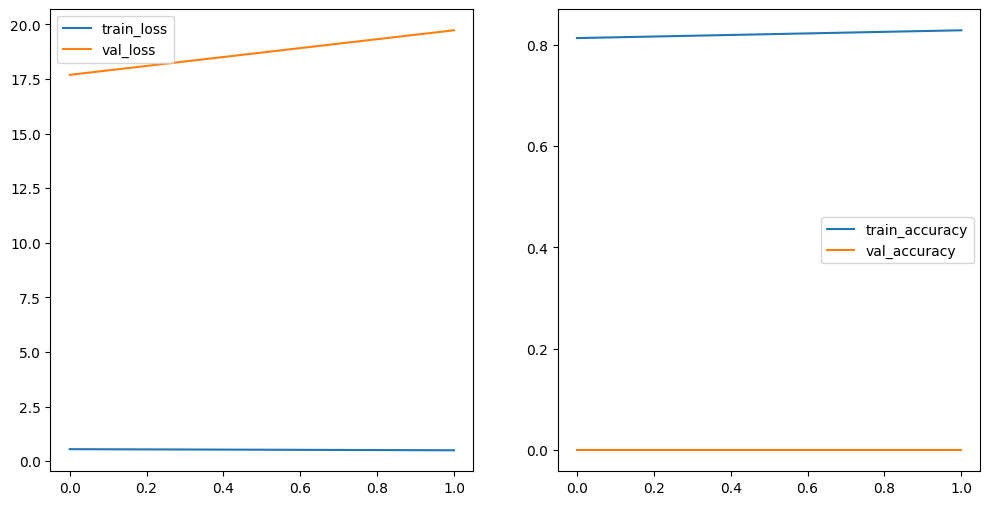

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_further_trained_best.h5'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.00001,
    verbose=1)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=2,  # The reduced number of epochs to ensure the training was completed, could be resulting in not training enough and increasing the overfitting.
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[model_checkpoint_callback, reduce_lr_callback])

further_trained_model_path = os.path.join(checkpoint_dir, 'model_further_trained_final.h5')
model.save(further_trained_model_path)
print(f"Further trained model saved to {further_trained_model_path}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

Augment to fix overfitting by increasing data augmentation of under representative classes

In [22]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/Colab Notebooks/Train'
augmented_train_dir = '/content/drive/MyDrive/Colab Notebooks/New Train'

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

def augment_class(class_directory, augment_factor, save_dir):

    image_files = [os.path.join(class_directory, f) for f in os.listdir(class_directory) if os.path.isfile(os.path.join(class_directory, f))]
    total_images = len(image_files) * augment_factor

    class_subdir = os.path.basename(class_directory)
    save_subdir = os.path.join(save_dir, class_subdir)
    if not os.path.exists(save_subdir):
        os.makedirs(save_subdir)

    i = 0
    for x, _ in datagen.flow_from_directory(train_dir, classes=[class_subdir], batch_size=1, save_to_dir=save_subdir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= total_images:
            break

class_augmentation_factors = {
    '0': 10,
    '6': 10,
    '3': 4,
    '4': 1,
    '5': 3,
    '7': 4,
    '8': 5,
    '9': 3,
    '1': 0,
    '2': 0,}

for class_dir, augment_factor in class_augmentation_factors.items():
    print(f"Augmenting {class_dir} by a factor of {augment_factor}")
    augment_class(os.path.join(train_dir, class_dir), augment_factor, augmented_train_dir)


print("Data augmentation complete.")

Augmenting 0 by a factor of 10
Found 210 images belonging to 1 classes.
Augmenting 6 by a factor of 10
Found 480 images belonging to 1 classes.
Augmenting 3 by a factor of 4
Found 1410 images belonging to 1 classes.
Augmenting 4 by a factor of 1
Found 1980 images belonging to 1 classes.
Augmenting 5 by a factor of 3
Found 1870 images belonging to 1 classes.
Augmenting 7 by a factor of 4
Found 1490 images belonging to 1 classes.
Augmenting 8 by a factor of 5
Found 1410 images belonging to 1 classes.
Augmenting 9 by a factor of 3
Found 1470 images belonging to 1 classes.
Augmenting 1 by a factor of 0
Found 2220 images belonging to 1 classes.
Augmenting 2 by a factor of 0
Found 2250 images belonging to 1 classes.
Data augmentation complete.


Fine tune to remove overfitting and save to .keras

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import os

model_path = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/model_further_trained_final.h5'

model = load_model(model_path)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_dir = '/content/drive/MyDrive/Colab Notebooks/Checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print("Model loaded and compiled.")

Model loaded and compiled.


462/462 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8463 
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/Colab Notebooks/Checkpoints/third_model_trained.keras
462/462 [==============================] - 9735s 21s/step - loss: 0.4583 - accuracy: 0.8463 - val_loss: 20.7893 - val_accuracy: 0.0000e+00 - lr: 1.0000e-04
Further trained model saved to /content/drive/MyDrive/Colab Notebooks/Checkpoints/third_model_trained.keras


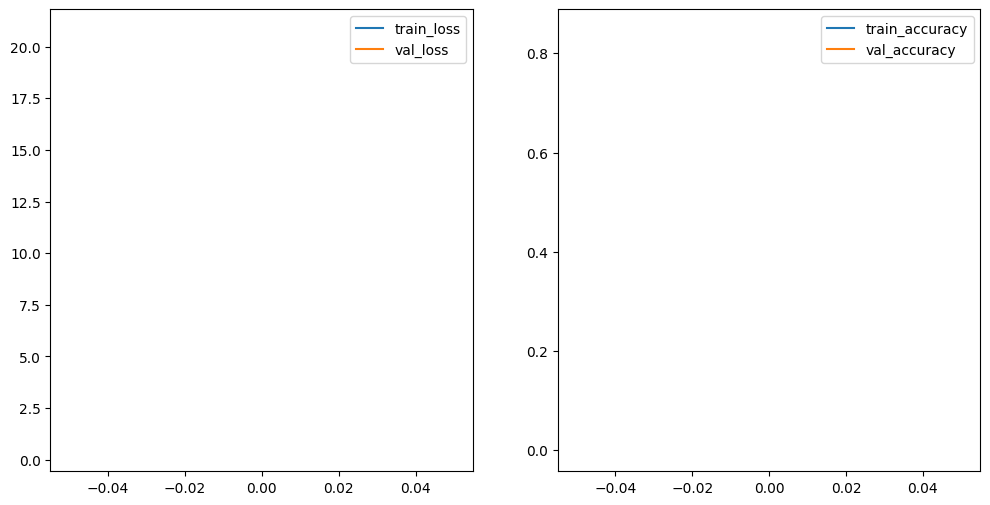

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

early_stopping = EarlyStopping(monitor='val_loss', patience=5)


model_checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'third_model_trained.keras'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)


reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.00001,
    verbose=1)

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=1,  # Depends on Computer Power, keep low. May have caused bad training and overfitting.
    validation_data=validation_generator,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[model_checkpoint_callback, reduce_lr_callback, early_stopping])

further_trained_model_path = os.path.join(checkpoint_dir, 'third_model_trained.keras')
model.save(further_trained_model_path)
print(f"Further trained model saved to {further_trained_model_path}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

#Predictive Test

Predict for the Best Model

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import os

test_images_directory = '/content/drive/MyDrive/Colab Notebooks/Test'
model_path = '/content/drive/MyDrive/best_model.h5'

model = load_model(model_path)
print("Model loaded successfully.")

def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        try:
            img = img_to_array(load_img(img_path, target_size=target_size))
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    images = np.array(images, dtype=np.float32)
    images = preprocess_input(images)
    return images

batch_size = 32

image_paths = []
for root, dirs, files in os.walk(test_images_directory):
    for file in files:
        if file.endswith('.png'):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} .png files for prediction.")

predictions = []

if not image_paths:
    print("No images found for prediction.")
else:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = load_and_preprocess_images(batch_paths)
        batch_predictions = model.predict(batch_images)
        predicted_classes = np.argmax(batch_predictions, axis=1)
        predictions.extend(predicted_classes)
        print(f"Processed batch {i//batch_size + 1}/{(len(image_paths)-1)//batch_size + 1}")

filename_predictions = dict(zip([os.path.basename(path) for path in image_paths], predictions))

print(filename_predictions)


{}


New Prediction for Futher Best Model

In [8]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
import numpy as np
import os

test_images_directory = '/content/drive/MyDrive/Colab Notebooks/Test'
fine_tuned_model_path = '/content/drive/MyDrive/Colab Notebooks/Checkpoints/third_model_trained.keras'


model = load_model(fine_tuned_model_path)
print("Model loaded successfully.")

def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in image_paths:
        try:
            img = img_to_array(load_img(img_path, target_size=target_size))
            images.append(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    images = np.array(images, dtype=np.float32)
    images = preprocess_input(images)
    return images


batch_size = 32

image_paths = []
for root, dirs, files in os.walk(test_images_directory):
    for file in files:
        if file.endswith('.png'):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} .png files for prediction.")

predictions = []

if not image_paths:
    print("No images found for prediction.")
else:
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_images = load_and_preprocess_images(batch_paths)
        batch_predictions = model.predict(batch_images)
        predicted_classes = np.argmax(batch_predictions, axis=1)
        predictions.extend(predicted_classes)
        print(f"Processed batch {i//batch_size + 1}/{(len(image_paths)-1)//batch_size + 1}")

    filename_predictions = dict(zip([os.path.basename(path) for path in image_paths], predictions))

    print(filename_predictions)

Model loaded successfully.
Found 12710 .png files for prediction.
1/1 [==============================] - 22s 22s/step
Processed batch 1/398
1/1 [==============================] - 20s 20s/step
Processed batch 2/398
1/1 [==============================] - 20s 20s/step
Processed batch 3/398
1/1 [==============================] - 20s 20s/step
Processed batch 4/398
1/1 [==============================] - 20s 20s/step
Processed batch 5/398
1/1 [==============================] - 21s 21s/step
Processed batch 6/398
1/1 [==============================] - 20s 20s/step
Processed batch 7/398
1/1 [==============================] - 20s 20s/step
Processed batch 8/398
1/1 [==============================] - 25s 25s/step
Processed batch 9/398
1/1 [==============================] - 21s 21s/step
Processed batch 10/398
1/1 [==============================] - 20s 20s/step
Processed batch 11/398
1/1 [==============================] - 20s 20s/step
Processed batch 12/398
1/1 [==============================] - 23s 

KeyboardInterrupt: ignored

Save to new predictive folder

In [3]:
new_predictions_directory = '/content/drive/MyDrive/Colab Notebooks/Predictions'

os.makedirs(new_predictions_directory, exist_ok=True)

for filename, predicted_class in filename_predictions.items():
    predicted_class_dir = os.path.join(new_predictions_directory, str(predicted_class))
    os.makedirs(predicted_class_dir, exist_ok=True)
    src_path = os.path.join(test_images_directory, filename)
    dst_path = os.path.join(predicted_class_dir, filename)

    shutil.copy(src_path, dst_path)

print(f"All images have been copied to the new prediction directory: {new_predictions_directory}")

All images have been copied to the new prediction directory: /content/drive/MyDrive/Colab Notebooks/Predictions


#Model's Evaluation

Evaluate the Best Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model


test_images_directory = '/content/drive/MyDrive/Colab Notebooks/Test'

model = load_model('/content/drive/MyDrive/best_model.h5')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_images_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

evaluation_results_path = '/content/drive/MyDrive/Colab Notebooks/evaluation_results.txt'
with open(evaluation_results_path, 'w') as file:
    file.write(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}\n")

print(f"Evaluation results saved to {evaluation_results_path}")

Evaluate the Further Best Model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

test_images_directory = '/content/drive/MyDrive/Colab Notebooks/Test'

model = load_model('/content/drive/MyDrive/Colab Notebooks/Checkpoints/third_model_trained.keras')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_images_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

further_test_loss, further_test_accuracy = model.evaluate(test_generator)
print(f"Further Test Loss: {further_test_loss}, Further Test Accuracy: {further_test_accuracy}")

further_evaluation_results_path = '/content/drive/MyDrive/Colab Notebooks/further_evaluation_results.txt'
with open(further_evaluation_results_path, 'w') as file:
    file.write(f"Further Test Loss: {further_test_loss}, Further Test Accuracy: {further_test_accuracy}\n")

print(f"Further evaluation results saved to {further_evaluation_results_path}")

Found 12710 images belonging to 10 classes.
  5/398 [..............................] - ETA: 2:14:57 - loss: 3.1265 - accuracy: 0.1688

#Confusion Matrix

In [ ]:
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

meta_csv_path = '/content/drive/MyDrive/Colab Notebooks/CSV Files/Meta.csv'
meta_df = pd.read_csv(meta_csv_path)

meta_df['Path'] = meta_df['Path'].apply(lambda x: os.path.basename(x))

meta_df.sort_values(by='Path', inplace=True)

image_paths = sorted(image_paths, key=lambda x: os.path.basename(x))

assert all(os.path.basename(path) == filename for path, filename in zip(image_paths, meta_df['Path']))

y_true = meta_df['ClassId'].values

y_pred = []
for i in range(0, len(image_paths), batch_size):
    batch_paths = image_paths[i:i+batch_size]
    batch_images = load_and_preprocess_images(batch_paths)
    batch_predictions = model.predict(batch_images)
    predicted_classes = np.argmax(batch_predictions, axis=1)
    y_pred.extend(predicted_classes)

# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Plot training & validation loss values

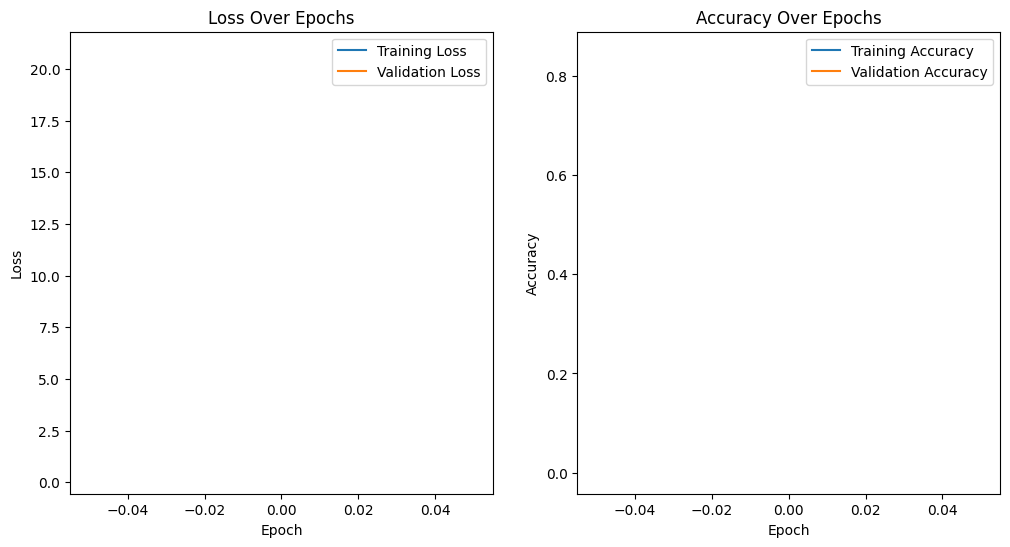

In [22]:
# Unable to plot the training loss and accuracy, as only one epoch ran in the last training.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()